In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors  
import numpy as np

## Import Data from CSV

In [3]:
csv_file_path = 'datasets/fakenewsnet.csv'
df = pd.read_csv(csv_file_path)
print(df.shape)
print("COLUMNS", df.columns.tolist())
df.iloc[0]

(20800, 4)
COLUMNS ['id', 'title', 'text', 'label']


id                                                       0
title    House Dem Aide: We Didn’t Even See Comey’s Let...
text     House Dem Aide: We Didn’t Even See Comey’s Let...
label                                                    1
Name: 0, dtype: object

## Data Preprocessing

In [4]:
# Imputing null values
null_imputation_dict = { 
    'id': 'None',
    'title': 'None',
    'text': 'None',
    'label': 'None'
    }
df = df.fillna(value=null_imputation_dict)

## Frequency Analysis on words

In [5]:
# import pandas as pd
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from collections import Counter

# # # Ensure you have the necessary nltk resources downloaded
# # nltk.download('punkt')
# # nltk.download('stopwords')
# def clean_and_tokenize(text):
#     tokens = word_tokenize(text)
#     # Remove punctuation and convert to lower case
#     words = [word.lower() for word in tokens if word.isalpha()]
#     # Remove stopwords
#     words = [word for word in words if word not in stopwords.words('english')]
#     return words

# # Apply this function to the 'text' column based on the label
# df['cleaned_text'] = df['text'].apply(clean_and_tokenize)
# fake_words = df[df['label'] == 1]['cleaned_text'].sum()
# real_words = df[df['label'] == 0]['cleaned_text'].sum()
# # Count word frequencies
# fake_word_counts = Counter(fake_words)
# real_word_counts = Counter(real_words)

# # Find words that are more common in fake news than in real news
# fake_indicator_words = {word: freq for word, freq in fake_word_counts.items() if freq > real_word_counts[word]}

# # Sort words by the difference in frequency compared to real news
# sorted_fake_indicators = sorted(fake_indicator_words.items(), key=lambda item: item[1] - real_word_counts[item[0]], reverse=True)
# print(sorted_fake_indicators[:20])

## Embedding

In [6]:

# TfIdf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
df.reset_index(drop=True, inplace=True)
df_article_embeddings = pd.concat([df[['id', 'label']], tfidf_df], axis=1)  
print(df_article_embeddings)



          id  label       000        10  100        11        12        15  \
0          0      1  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   
1          1      0  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   
2          2      1  0.000000  0.000000  0.0  0.017959  0.000000  0.000000   
3          3      1  0.000000  0.000000  0.0  0.000000  0.000000  0.138463   
4          4      1  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   
...      ...    ...       ...       ...  ...       ...       ...       ...   
20795  20795      0  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   
20796  20796      0  0.000000  0.000000  0.0  0.017838  0.000000  0.018636   
20797  20797      0  0.023688  0.024605  0.0  0.057143  0.031656  0.000000   
20798  20798      1  0.000000  0.043436  0.0  0.050439  0.000000  0.000000   
20799  20799      1  0.060881  0.000000  0.0  0.024477  0.000000  0.000000   

             16   20  ...  wrong  wrote      year     years  ye

## Split Training and Test Data

In [7]:
X = df_article_embeddings.drop(['id', 'label'], axis=1)  # Features (embeddings)
y = df_article_embeddings['label']  # Labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Select and Train Model**

Using Logistic Regression for Classification

In [8]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

**Decision Tree**

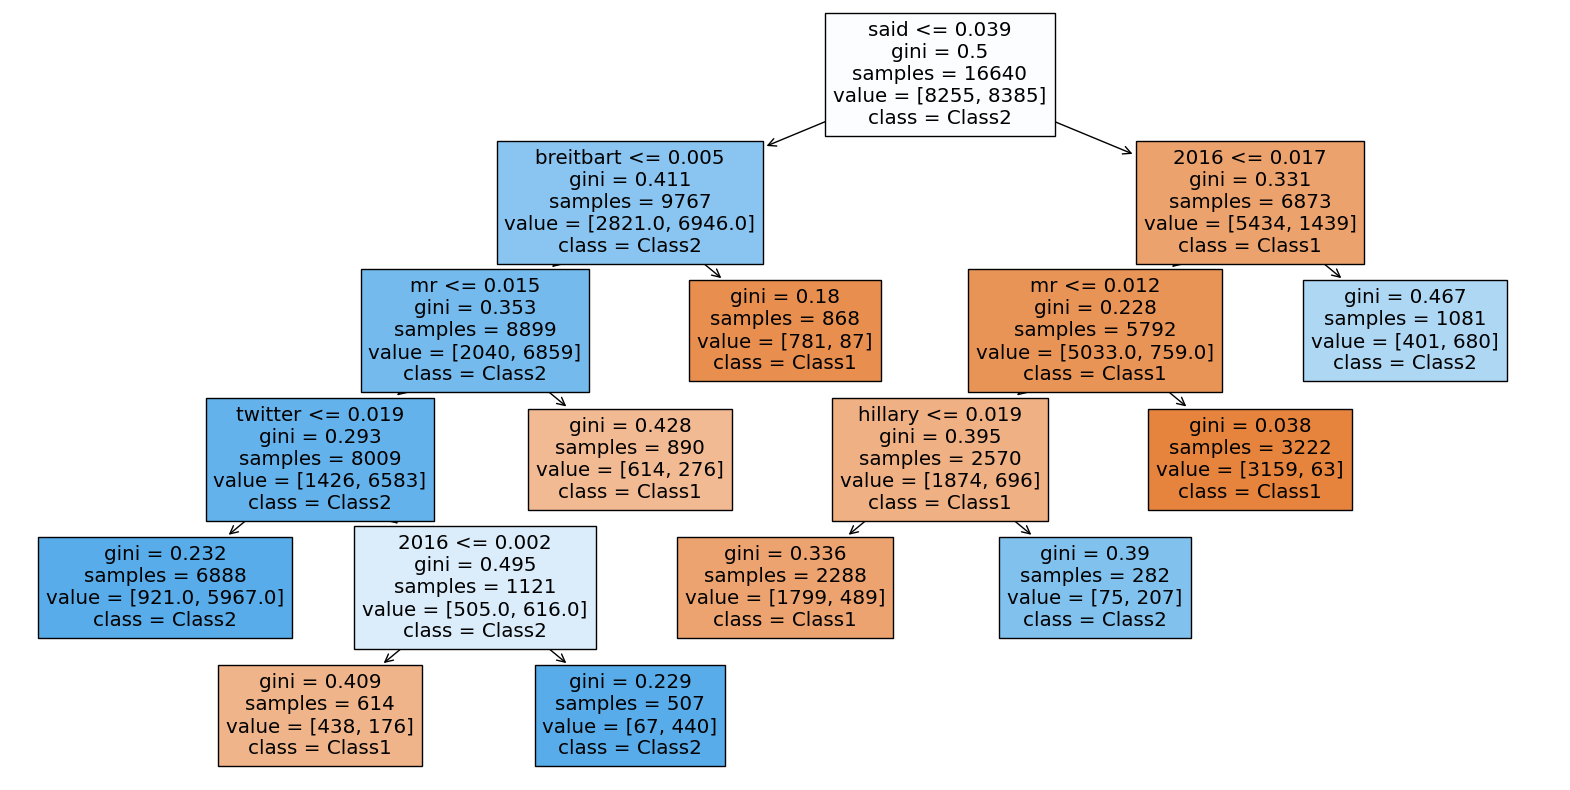

In [9]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree Classifier
dt_model = DecisionTreeClassifier(ccp_alpha=0.005)

# Fit the Decision Tree model on the training data
dt_model.fit(X_train, y_train)


# Plot the decision tree
plt.figure(figsize=(20,10))  # Set the size of the figure
plot_tree(dt_model, filled=True, feature_names=X_train.columns, class_names=['Class1', 'Class2'])
plt.show()


In [10]:
from sklearn.tree import export_text

tree_rules = export_text(dt_model, feature_names=list(X_train.columns))
print(tree_rules)


|--- said <= 0.04
|   |--- breitbart <= 0.00
|   |   |--- mr <= 0.02
|   |   |   |--- twitter <= 0.02
|   |   |   |   |--- class: 1
|   |   |   |--- twitter >  0.02
|   |   |   |   |--- 2016 <= 0.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- 2016 >  0.00
|   |   |   |   |   |--- class: 1
|   |   |--- mr >  0.02
|   |   |   |--- class: 0
|   |--- breitbart >  0.00
|   |   |--- class: 0
|--- said >  0.04
|   |--- 2016 <= 0.02
|   |   |--- mr <= 0.01
|   |   |   |--- hillary <= 0.02
|   |   |   |   |--- class: 0
|   |   |   |--- hillary >  0.02
|   |   |   |   |--- class: 1
|   |   |--- mr >  0.01
|   |   |   |--- class: 0
|   |--- 2016 >  0.02
|   |   |--- class: 1



Using KNN to find similar articles

In [11]:
# knn_model = NearestNeighbors(n_neighbors=8, algorithm='ball_tree')
# knn_model.fit(X)

## Test Model Accuracy

In [17]:
from sklearn.metrics import accuracy_score, classification_report

# Predict labels for the test set
y_pred = lr_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Detailed performance analysis
print(classification_report(y_test, y_pred))

Accuracy: 0.9348557692307692
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2132
           1       0.93      0.94      0.93      2028

    accuracy                           0.93      4160
   macro avg       0.93      0.93      0.93      4160
weighted avg       0.93      0.93      0.93      4160



## Classify new article with Logistic Regression + SHAP

In [53]:
import shap

new_article_text = "US Helicopters are flying over South-East Asia"

# Predict a new article
new_text = [new_article_text]
new_text_vectorized = tfidf_vectorizer.transform(new_text)

# Predict the class of the new text
prediction = lr_model.predict(new_text_vectorized)
print("The predicted class of the new article is:", prediction[0])

def predict_proba(texts):
    vectorized_texts = tfidf_vectorizer.transform(texts)
    return lr_model.predict_proba(vectorized_texts)

# Set up a background dataset for SHAP
background_data = shap.sample(X_test, 1)  # Sample 100 instances to form a background dataset
background_data = np.reshape(background_data, (1000,))
# Initialize SHAP Explainer
# Use the KernelExplainer for a more general approach as we are using a dense data format (TF-IDF vectors)
explainer = shap.Explainer(predict_proba, background_data, link=shap.links.logit)

# SHAP
shap_values = explainer(new_article_text)
shap.initjs()
shap.plots.text(shap_values)

The predicted class of the new article is: 1


/Users/newswav/Documents/FYPFakeNews/fyp/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


IndexError: tuple index out of range

In [14]:
# from sentence_transformers import SentenceTransformer
# s_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# # Obtain the embedding
# new_article_embedding = s_model.encode([new_article_text])[0]


# def classify_article(article_embedding, lr_model):
#     prediction = lr_model.predict([article_embedding])
#     return prediction[0]

# # Example usage assuming lr_model is your trained LogisticRegression classifier
# predicted_label = classify_article(new_article_embedding, lr_model)
# if predicted_label == 1:
#     predicted_label = 'FALSE'
# if predicted_label == 0:
#     predicted_label = 'TRUE'

# print(f"The article is predicted to be: {predicted_label}")



In [15]:
# from sklearn.neighbors import NearestNeighbors

# # Assuming you have fitted the NearestNeighbors model as shown earlier (knn_model)
# # And new_article_embedding is the embedding for the new article

# # Find the 5 nearest neighbors for the new article
# distances, indices = knn_model.kneighbors([new_article_embedding])

# similar_articles_info = df.iloc[indices[0]][['title', 'label']]

# # Print the titles and labels of the most similar articles
# result_fake = []
# result_real = []
# for _, row in similar_articles_info.iterrows():
#     if row['label'] == 1 or row['label'] == 'FALSE':
#         result_fake.append(row)
#     else:
#         result_real.append(row)
    
# for row in result_real:
#     print(f"{row['label']} | Title: {row['title']}")

# print("\n")

# for row in result_fake:
#     print(f"{row['label']} | Title: {row['title']}")

## Results

**2/4**
- Dataset: FakeNewsNet
- Embedding: SentenceTransformer, only on title
- Classification: Logistic Regression
- Similar articles: KNN

Accuracy: 0.9105769230769231
              precision    recall  f1-score   support

        REAL       0.93      0.89      0.91      2132
        FAKE       0.89      0.93      0.91      2028

    accuracy                           0.91      4160
   macro avg       0.91      0.91      0.91      4160
weighted avg       0.91      0.91      0.91      4160

Comments: Sometimes articles can be classified as fake even though all nearest neighbours are real.

22/4
- Tfidf for vectorizing (1000 max features)
- Decision Tree for classification

Accuracy: 0.8745192307692308
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      2132
           1       0.87      0.87      0.87      2028

    accuracy                           0.87      4160
   macro avg       0.87      0.87      0.87      4160
weighted avg       0.87      0.87      0.87      4160